<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [109]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [4]:
#!pip -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [110]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [111]:
df.shape

(346, 10)

### Convert to date time object 

In [112]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

df.drop(columns=['Gender'], axis=1)
df['Sex'] = df['Gender']

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,Sex
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [113]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [9]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

<Figure size 864x576 with 0 Axes>

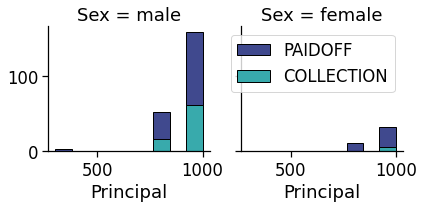

In [115]:
import seaborn as sns

plt.figure(figsize=(12,8))

#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)

g = sns.FacetGrid(df, col="Sex", hue="loan_status", palette="mako", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()

plt.show()

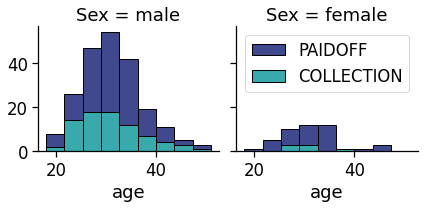

In [116]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Sex", hue="loan_status", palette="mako", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

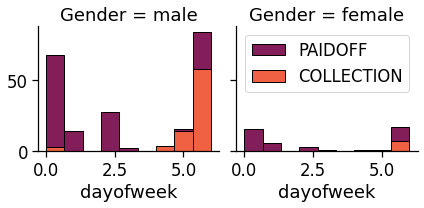

In [117]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="rocket", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [118]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,Sex,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,male,4,1


## Convert Categorical features to numerical values

Lets look at Sex:

In [119]:
df.groupby(['Sex'])['loan_status'].value_counts(normalize=True)

Sex     loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [120]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,Sex,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,0,4,1


## One Hot Encoding  
#### How about education?

In [121]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [122]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Sex,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [123]:
Feature = df[['Principal','terms','age','Sex','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Sex,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [124]:
X = Feature
X[0:5]

,Principal,terms,age,Sex,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [125]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [126]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [127]:
df = pd.read_csv('teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

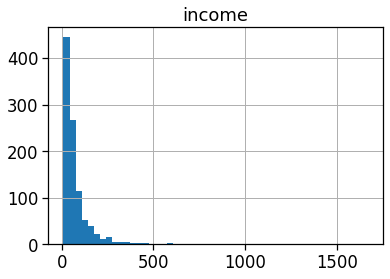

In [128]:
df['custcat'].value_counts()
df.hist(column='income', bins=50)
df.columns


In [129]:
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']].values
X[0:5]

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

In [130]:
y = df['custcat'].values
y[0:5]


array([1, 4, 3, 1, 3])

In [131]:
# normalize data
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
#X[0:5]

# train /test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (800, 11) (800,)
Test set: (200, 11) (200,)


In [194]:
# training model 

from sklearn.neighbors import KNeighborsClassifier

k=2
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [195]:
yhat = neigh.predict(X_test)
yhat[0:5]


array([0, 0, 0, 0, 0])

In [196]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))


Train set Accuracy:  0.84375
Test set Accuracy:  0.7


In [135]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

for n in range(1,Ks): 
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors =  
            n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]= np.std(yhat==y_test) / np.sqrt(yhat.shape[0])

mean_acc


array([0.3  , 0.29 , 0.315, 0.32 , 0.315, 0.31 , 0.335, 0.325, 0.34 ])

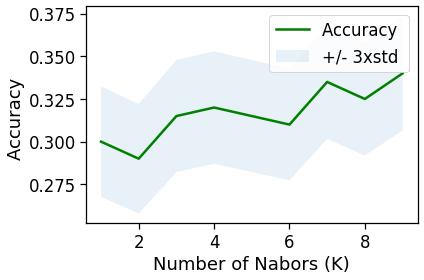

The best accuracy was with 0.34 with k= 9


In [136]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


In [178]:
from sklearn.metrics import jaccard_similarity_score
KNN_jac = jaccard_similarity_score(y_test, yhat)
print(' KNN Jaccard =', KNN_jac)

 KNN Jaccard = 0.75


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [187]:
from sklearn.metrics import f1_score

KNN_f1 = f1_score(y_test, yhat, average='weighted') 
print('KNN f1 =',KNN_f1 )

KNN f1 = 0.7217868338557994


# Decision Tree

In [137]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:5]


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [138]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]


array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.113999999999999],
       [28, 'F', 'NORMAL', 'HIGH', 7.797999999999999],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [142]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.113999999999999],
       [28, 0, 2, 0, 7.797999999999999],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [143]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

In [144]:
from sklearn.model_selection import train_test_split

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

print(' X_trainset = ', X_trainset.shape)
print(' y_trainset = ', y_trainset.shape)

print(' X_testset = ', X_testset.shape)
print(' y_testset = ', y_testset.shape)


 X_trainset =  (140, 5)
 y_trainset =  (140,)
 X_testset =  (60, 5)
 y_testset =  (60,)


In [145]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree 


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [146]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [147]:
predTree = drugTree.predict(X_testset)

In [148]:
print(predTree [0:5])
print(y_testset [0:5])


['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


In [149]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))


DecisionTrees's Accuracy:  0.9833333333333333


In [180]:
from sklearn.metrics import jaccard_similarity_score
DecTree_jac = jaccard_similarity_score(y_test, yhat)
print(' Decision Tree jaccard =',DecTree_jac)

 Decision Tree jaccard = 0.75


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [184]:
from sklearn.metrics import f1_score

DecTree_f1 = f1_score(y_test, yhat, average='weighted')
print('Decision Tree f1 = ',DecTree_f1)

Decision Tree f1 =  0.7217868338557994


# Support Vector Machine

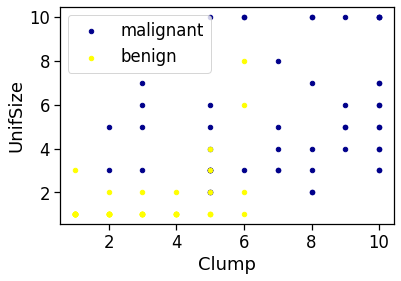

In [152]:
cell_df =pd.read_csv("cell_samples.csv")

ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');

cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

In [153]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes



ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [154]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]


array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [155]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]


array([2, 2, 2, 2, 2])

In [156]:
# train test split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


In [157]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [158]:
yhat = clf.predict(X_test)
yhat [0:5]


array([2, 4, 2, 4, 2])

In [182]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from sklearn.metrics import f1_score
SVM_f1 = f1_score(y_test, yhat, average='weighted')
print('SVM f1 ', SVM_f1 )


from sklearn.metrics import jaccard_similarity_score
SVM_jac = jaccard_similarity_score(y_test, yhat)
print('SVM jaccard =', SVM_jac)



SVM f1  0.7217868338557994
SVM jaccard = 0.75


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [161]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))


Avg F1-score: 0.9639
Jaccard score: 0.9635


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Logistic Regression

In [162]:
churn_df = pd.read_csv("ChurnData.csv")

churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()


,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


In [163]:
churn_df.shape

(200, 10)

In [164]:
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
X[0:5]


array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

In [165]:
y = np.asarray(churn_df['churn'])
y [0:5]


array([1, 1, 0, 0, 0])

In [166]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]


array([[-1.13518441, -0.62595491, -0.4588971 ,  0.4751423 ,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, -0.32886061, -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , -0.35227817, -1.42318853,
        -0.92053635, -0.85972695],
       [ 0.11557989, -0.47262854, -0.65627219,  0.00679109, -0.6433592 ,
        -0.02518185,  1.16316   ],
       [-1.32048283, -0.47262854,  0.23191574,  0.03801451, -0.6433592 ,
         0.53441472, -0.85972695]])

In [167]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (160, 7) (160,)
Test set: (40, 7) (40,)


In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
yhat = LR.predict(X_test)
yhat


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [170]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob


array([[0.54132919, 0.45867081],
       [0.60593357, 0.39406643],
       [0.56277713, 0.43722287],
       [0.63432489, 0.36567511],
       [0.56431839, 0.43568161],
       [0.55386646, 0.44613354],
       [0.52237207, 0.47762793],
       [0.60514349, 0.39485651],
       [0.41069572, 0.58930428],
       [0.6333873 , 0.3666127 ],
       [0.58068791, 0.41931209],
       [0.62768628, 0.37231372],
       [0.47559883, 0.52440117],
       [0.4267593 , 0.5732407 ],
       [0.66172417, 0.33827583],
       [0.55092315, 0.44907685],
       [0.51749946, 0.48250054],
       [0.485743  , 0.514257  ],
       [0.49011451, 0.50988549],
       [0.52423349, 0.47576651],
       [0.61619519, 0.38380481],
       [0.52696302, 0.47303698],
       [0.63957168, 0.36042832],
       [0.52205164, 0.47794836],
       [0.50572852, 0.49427148],
       [0.70706202, 0.29293798],
       [0.55266286, 0.44733714],
       [0.52271594, 0.47728406],
       [0.51638863, 0.48361137],
       [0.71331391, 0.28668609],
       [0.

In [171]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.86      0.40      0.55        15

    accuracy                           0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [189]:
from sklearn.metrics import f1_score

LogReg_f1 = f1_score(y_test, yhat, average='weighted') 
print('Log Reg f1 =',LogReg_f1)

Log Reg f1 = 0.7217868338557994


In [191]:
from sklearn.metrics import jaccard_similarity_score

LogReg_jac = jaccard_similarity_score(y_test, yhat)
print('Log Reg Jaccard =', LogReg_jac)

Log Reg Jaccard = 0.75


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [192]:
from sklearn.metrics import log_loss

LogReg_LogLoss = log_loss(y_test, yhat_prob)
print('Log Reg Log Loss =', LogReg_LogLoss)

Log Reg Log Loss = 0.6017092478101185


# Model Evaluation using Test set

In [173]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>